--------------------------------------------------------------------

# WELCOME TO THE ALGORITHMIC WORLD OF QUANTUM 
--------------------------------------------------------------------


# Instructions

1. We will learn the implementation of the **Bernstein-Vazirani algorithm** using Qiskit.
2. The Bernstein-Vazirani algorithm allows us to determine a **secret bitstring** stored inside a black box (oracle).
3. Read the code provided below, then **answer the following questions** and **prepare a report based on your findings**.

---

### Refrences:


[1] Ethan Bernstein and Umesh Vazirani (1997) "Quantum Complexity Theory" SIAM Journal on Computing, Vol. 26, No. 5: 1411-1473,[doi:10.1137/S0097539796300921](https://doi.org/10.1137/S0097539796300921).

[2] Bernstein–Vazirani algorithm - [Wikipedia](https://en.wikipedia.org/wiki/Bernstein%E2%80%93Vazirani_algorithm)

[3] You can learn more about the Bernstein-Vazirani algorithm in qiskit textbook [here](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html).

**GOOD LUCK!!**




#### Execute the below instructions for the required packages 


In [1]:
#UNCOMMENT below for installation

# pip install qiskit
# pip install qiskit_aer
# pip install qiskit[visualization]
# pip install matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile

from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator

In [2]:
n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string

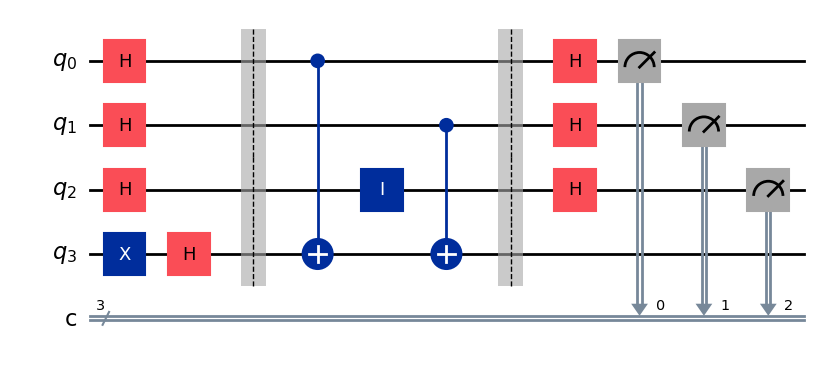

In [3]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.x(n)
bv_circuit.h(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.id(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw('mpl')

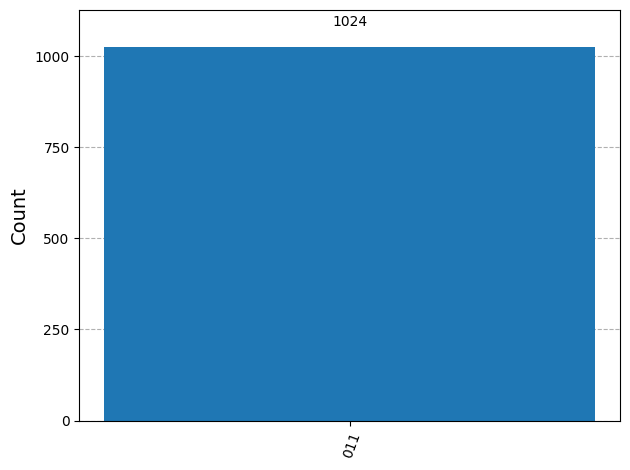

In [4]:
# use local simulator
aer_sim =  AerSimulator(method='statevector')

shots = 1024
# qobj = assemble(bv_circuit)
results = aer_sim.run(bv_circuit).result()
answer = results.get_counts()

plot_histogram(answer)

## Question 1: Dynamic Secret Bitstring

### Dynamic secret bitstring: Modify the existing tutorial so that the secret string s can be input dynamically (of any length $n$). Update the circuit construction code to use the bits of s in the oracle and verify that measuring the output qubits recovers s. Test with several random secrets and increasing $n$. This demonstrates the signature property that the quantum algorithm finds the $n$-bit secret in one shot (whereas a classical procedure needs $n$ queries)


In [8]:
def b_v_circuit(s: str) -> QuantumCircuit:
    n = len(s)
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(n)
    for qubit in range(n):
        qc.h(qubit)
    qc.barrier()
    
    # WRITE YOUR CODE HERE
    s = s[::-1] # reverse s to fit qiskit's qubit ordering
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(i, n)
    
    qc.barrier()
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.measure(qubit, qubit)
    return qc

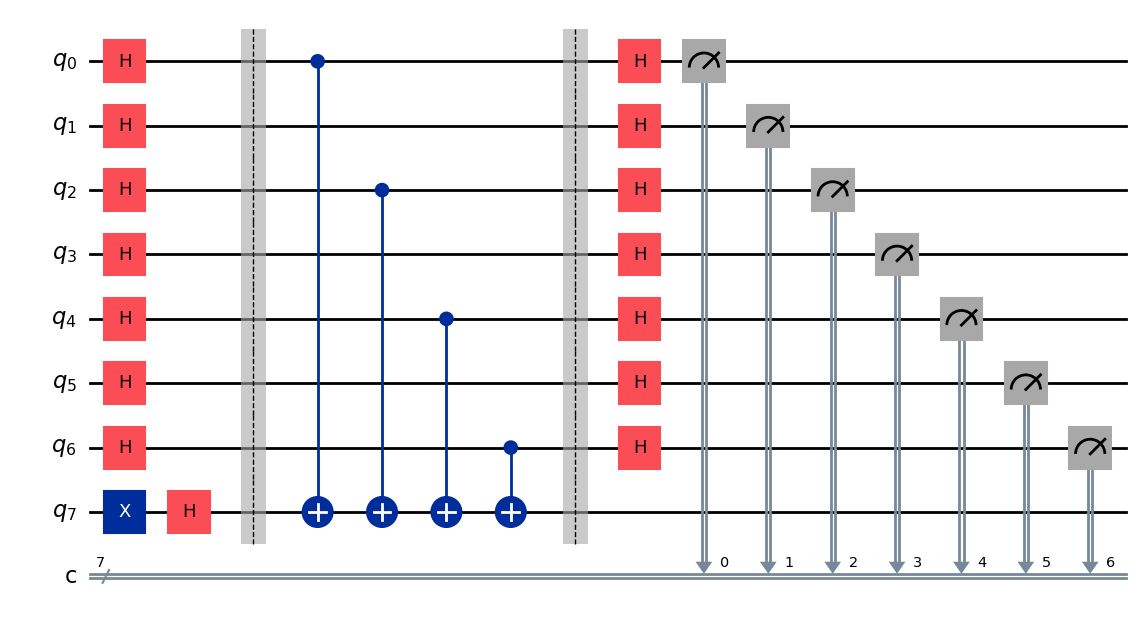

In [30]:
secret = '1010101'
qc = b_v_circuit(secret)
qc.draw('mpl')

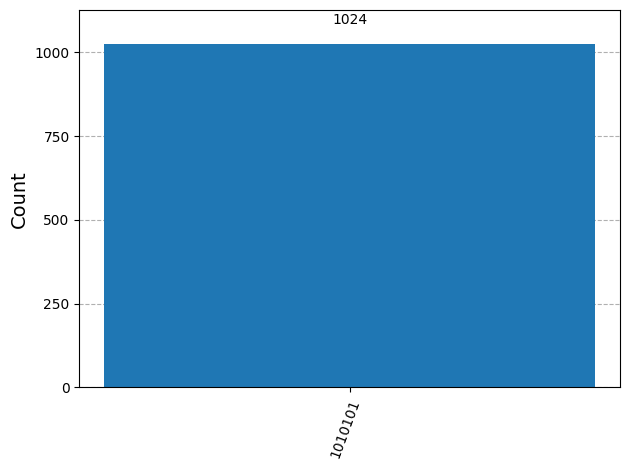

In [31]:
# use local simulator
aer_sim =  AerSimulator(method='statevector')

shots = 1024
# qobj = assemble(bv_circuit)
results = aer_sim.run(qc).result()
answer = results.get_counts()

plot_histogram(answer)

## Question 2: Alternative Oracle using Phase Kickback

### Replace the standard CNOT-based oracle with a phase oracle. Show that this “phase kickback” version yields the same measured result bits as the original (i.e. the secret string) after the final Hadamards. This tests understanding of different oracle constructions that encode $s$ via phase instead of X-flips. Write your views on how this phase oracle will be benificial as compared to the previous one(CNOT's one). 

##### Hint : For example, prepare the ancilla qubit in $|-\rangle$ (apply H to $|1\rangle$), use controlled-Z (or controlled-phase) gates from each data qubit onto the ancilla to encode the secret, then undo the Hadamard on the ancilla.

In [36]:
def bv_phase_oracle_circuit(s: str) -> QuantumCircuit:
    n = len(s)
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(n)
    
    # WRITE YOUR CODE HERE
    for qubit in range(n):
        qc.h(qubit)
    qc.barrier()
    s = s[::-1] # reverse s to fit qiskit's qubit ordering
    for i, bit in enumerate(s):
        if bit == '1':
            qc.h(n)
            qc.cz(i, n)
            qc.h(n)
    
    qc.barrier()
    qc.h(range(n))
    qc.barrier()
    qc.measure(range(n), range(n))
    return qc

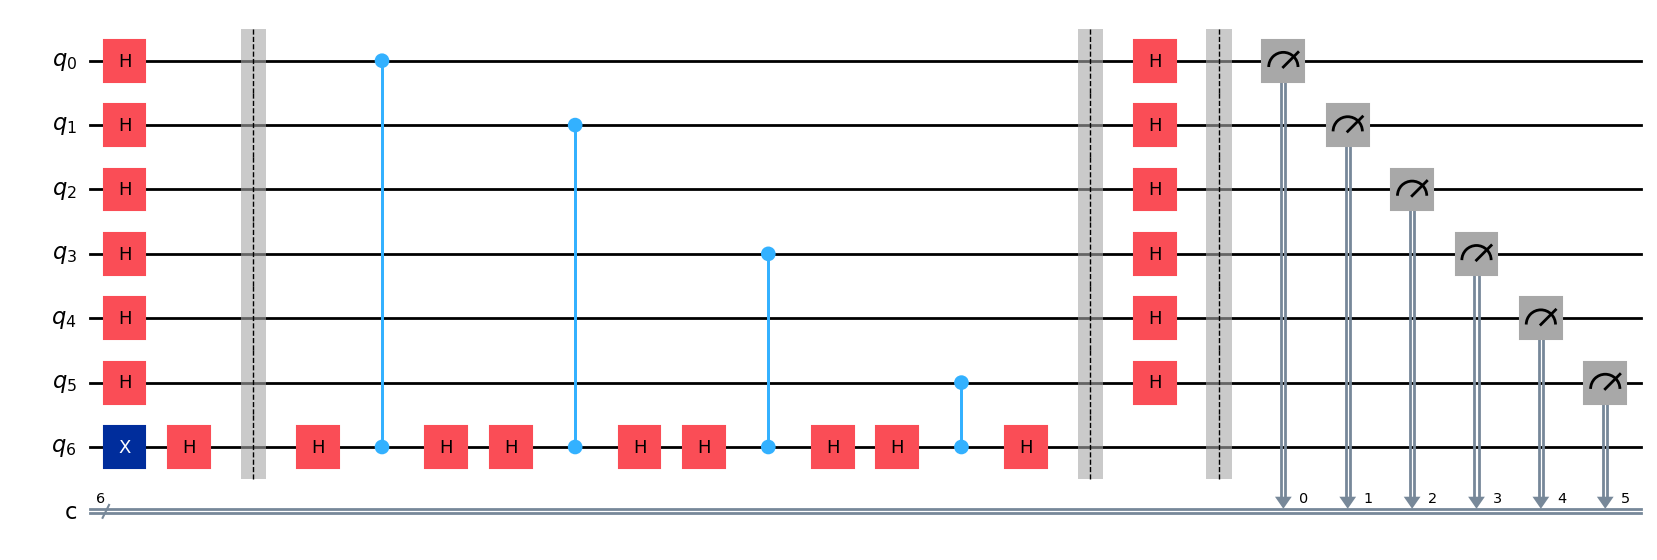

In [41]:
secret = '101011'
qc = bv_phase_oracle_circuit(secret)
qc.draw('mpl')

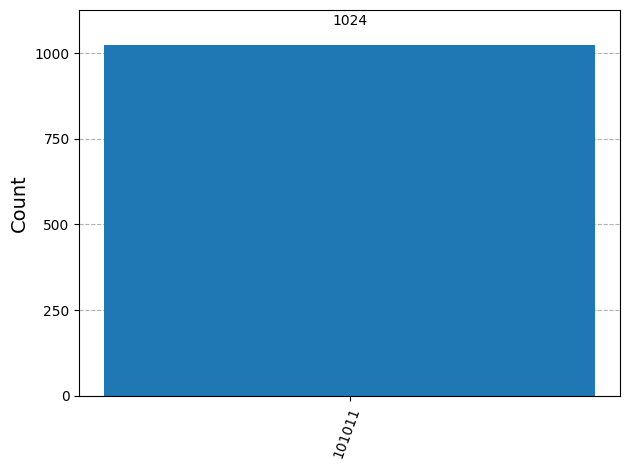

In [42]:
# use local simulator
aer_sim =  AerSimulator(method='statevector')

shots = 1024
# qobj = assemble(bv_circuit)
results = aer_sim.run(qc).result()
answer = results.get_counts()

plot_histogram(answer)

## Question 3: Classical vs. quantum performance:

### We implemented the classical strategy for finding the secret: query the oracle (simulate the function $f(x)=s\cdot x \bmod 2$) on each basis vector to recover one bit of s at a time. The code requires $n$ queries to learn all bits of s. Contrast this with the quantum algorithm’s single query. Measure (or count) the number of operations or time taken by both approaches for increasing $n$. Write an report to discuss the observed quantum speedup in terms of queries and actual run time.

In [43]:
def classical_bv(s: str) -> str:
    def oracle(x):
        return sum(int(s[i]) & int(x[i]) for i in range(len(s))) % 2
    result = ''
    for i in range(len(s)):
        x = ['0'] * len(s)
        x[i] = '1'
        result += str(oracle(''.join(x)))
    return result



In [44]:
secret = '1101'
print(classical_bv(secret))

1101


### Quantum Execution (as before):

In [45]:
qc = b_v_circuit(secret)
aer_sim =  AerSimulator(method='statevector')

shots = 1024
# qobj = assemble(bv_circuit)
result = aer_sim.run(qc).result()
quantum_result = max(result.get_counts(), key=result.get_counts().get)
print(f"Quantum Result: {quantum_result}")

Quantum Result: 1101


### Interpretation:
The classical version requires $n$ queries

The quantum version gives the correct answer with a single query.

This illustrates the exponential query speedup of the quantum algorithm.


In [85]:
report = """
Classical Approach:
-------------------
Problem:
Given a hidden bit string s, determine the value of s.

Oracle:
A function f(x) = s · x, where · represents the inner product modulo 2.

Solution:
Requires n queries (n = length(s)) to determine each bit of s. We query the oracle for each bit position.

Quantum Approach:
-----------------
Problem:
Same as the classical approach.

Oracle:
Same as the classical approach.

Solution:
Uses a quantum circuit involving Hadamard gates, CNOT gates, and measurements. It leverages superposition to efficiently find the secret string s with a single query to the oracle.

Key Differences:
----------------
1. Number of Queries:
    - The quantum algorithm needs only one oracle call, whereas the classical algorithm needs n calls.

2. Computational Speed:
    - The quantum algorithm is faster in terms of oracle calls, demonstrating a linear speedup.

3. Underlying Principles:
    - The quantum algorithm utilizes quantum phenomena like superposition, while the classical algorithm relies on bit manipulations and logical reasoning.
"""
print(report)


Classical Approach:
-------------------
Problem:
Given a hidden bit string s, determine the value of s.

Oracle:
A function f(x) = s · x, where · represents the inner product modulo 2.

Solution:
Requires n queries (n = length(s)) to determine each bit of s. We query the oracle for each bit position.

Quantum Approach:
-----------------
Problem:
Same as the classical approach.

Oracle:
Same as the classical approach.

Solution:
Uses a quantum circuit involving Hadamard gates, CNOT gates, and measurements. It leverages superposition to efficiently find the secret string s with a single query to the oracle.

Key Differences:
----------------
1. Number of Queries:
    - The quantum algorithm needs only one oracle call, whereas the classical algorithm needs n calls.

2. Computational Speed:
    - The quantum algorithm is faster in terms of oracle calls, demonstrating a linear speedup.

3. Underlying Principles:
    - The quantum algorithm utilizes quantum phenomena like superposition, whi

## Question 4: Circuit Metrics: Depth and Gate Count

### For several values of $n$ (e.g. 4, 6, 8), construct the B_V circuit and use QuantumCircuit.depth() and QuantumCircuit.count_ops() to obtain the circuit depth and the number of gates. Plot how the depth and total gate count scale with $n$. Discuss whether the depth grows linearly or faster with $n$, and how this impacts practical run time and identify which operations (Hadamards or CNOTs) dominate the circuit complexity in your report.

#### References:
#### [1]For circuit gate depth [click here](https://docs.quantum.ibm.com/api/qiskit/0.19/qiskit.circuit.QuantumCircuit#:~:text=depth) 
####  [2]For the operation counts [click here](https://docs.quantum.ibm.com/api/qiskit/0.19qiskit.circuit.QuantumCircuit#:~:text=count_ops) 

In [67]:
import matplotlib.pyplot as plt
import random 

depths = []
gate_counts = []

# define 'n1' and 'n2' as per your need
sizes = list(range(4, 16))

for n in sizes:
    secret = ''.join(random.choice('01') for _ in range(n))
    qc = b_v_circuit(secret)
    
   # WRITE YOUR CODE HERE
    depths.append(qc.depth())
    gate_counts.append(qc.count_ops().get('cx', 0) + qc.count_ops().get('h', 0) + qc.count_ops().get('x', 0) + qc.count_ops().get('id', 0))


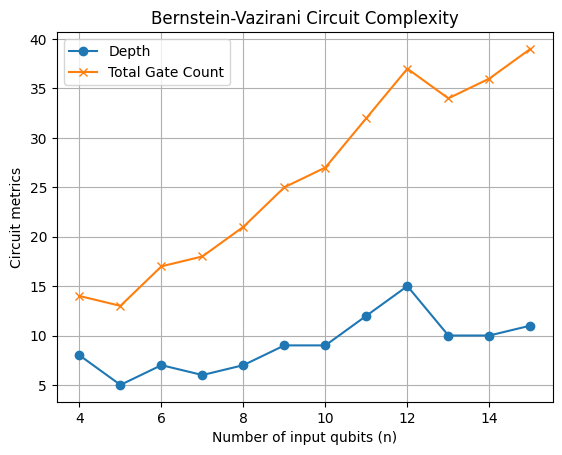

In [68]:
plt.plot(sizes, depths, marker='o', label='Depth')
plt.plot(sizes, gate_counts, marker='x', label='Total Gate Count')
plt.xlabel('Number of input qubits (n)')
plt.ylabel('Circuit metrics')
plt.legend()
plt.title('Bernstein-Vazirani Circuit Complexity')
plt.grid(True)
plt.show()

## Question 5: Advance variant of B-V algorithm 

###  Consider an oracle that hides two secret bit-strings (i.e. $f(x)$ returns two bits, each a dot product with a different secret). Describe and implement the modified circuit for your variant, and run experiments to see if the secrets can be recovered. Discuss any limitations or differences compared to the standard BV case in the report.

In [92]:
def b_v_dual_secret(s1: str, s2: str):
    n = len(s1)
    qc = QuantumCircuit(n + 2, n * 2)
    
    ## WRITE YOUR HERE HERE 
    
    # Initialize two ancilla qubits in |1⟩ → |−⟩
    qc.x(n)
    qc.h(n)
    qc.x(n+1)
    qc.h(n+1)

    # Hadamard on input qubits
    qc.h(range(n))
    
    # Oracle for both s1 and s2
    oracle = QuantumCircuit(n + 2)
    for i, bit in enumerate(s1[::-1]):
        if bit == '1':
            oracle.cx(i, n)  # output qubit 1 (index n)
    for i, bit in enumerate(s2[::-1]):
        if bit == '1':
            oracle.cx(i, n+1)  # output qubit 2 (index n+1)

    qc.compose(oracle, inplace=True)
    qc.barrier()
    
    # Second Hadamard
    qc.h(range(n))
    qc.barrier()
    
    # Measurement
    qc.measure(range(n), range(n))  # Measure first n qubits
    qc.measure(range(n), range(n, 2*n))
    # Ancillas not measured here; optional to verify if needed

    return qc



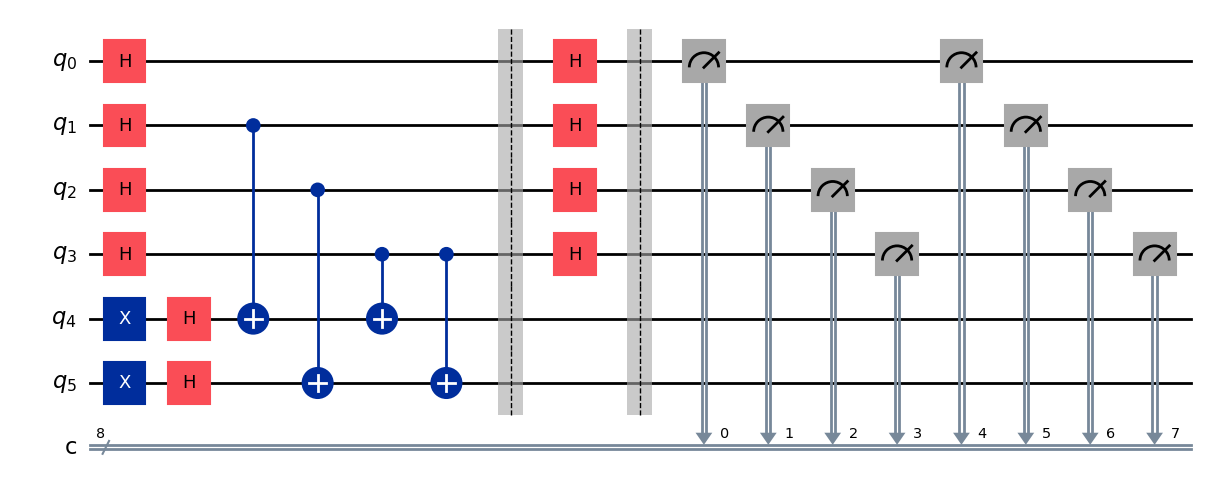

In [93]:
# Example
s1 = '1010'
s2 = '1100'
qc = b_v_dual_secret(s1, s2)
qc.draw('mpl')


In [94]:
aer_sim =  AerSimulator(method='statevector')

shots = 1024
# qobj = assemble(bv_circuit)
result = aer_sim.run(qc).result()
quantum_result = result.get_counts()
print(f"Quantum Result of s1: {list(quantum_result.items())[0][0][:len(s1)]} \
       \nQuantum Result of s2: {list(quantum_result.items())[0][0][len(s2):]}")

Quantum Result of s1: 0110        
Quantum Result of s2: 0110


In [95]:
report = """
Dual Bernstein-Vazirani Problem:
-----------------------------
Problem:
Given two hidden bit strings s1 and s2, determine the values of both strings.
Oracle:
A function f(x) = s1 · x for the first string and g(x) = s2 · x for the second string, where · represents the inner product modulo 2.
Solution:
The quantum circuit uses Hadamard gates to create superposition, applies a oracle for both strings, and measures the results.
Limitations:
    -   Standard BV recovers 1 string with 1 query.
    -   Dual BV tries to recover 2 strings — since it spreads entanglement across 2 ancillas, the output may show only one clear bitstring per shot.
    -   It will show xored results of both strings, which may not be directly interpretable as two distinct strings.
"""
print(report)


Dual Bernstein-Vazirani Problem:
-----------------------------
Problem:
Given two hidden bit strings s1 and s2, determine the values of both strings.
Oracle:
A function f(x) = s1 · x for the first string and g(x) = s2 · x for the second string, where · represents the inner product modulo 2.
Solution:
The quantum circuit uses Hadamard gates to create superposition, applies a oracle for both strings, and measures the results.
Limitations:
    -   Standard BV recovers 1 string with 1 query.
    -   Dual BV tries to recover 2 strings — since it spreads entanglement across 2 ancillas, the output may show only one clear bitstring per shot.
    -   It will show xored results of both strings, which may not be directly interpretable as two distinct strings.

